Early stopping at step 257, final point: tensor([-2.8051,  3.1313]), grad norm: 0.000148
Elapsed time: 0.06 seconds
Loss < 10.0 reached at iteration 63
Loss < 1.0 reached at iteration 86
Loss < 0.1 reached at iteration 104
Loss < 0.01 reached at iteration 122


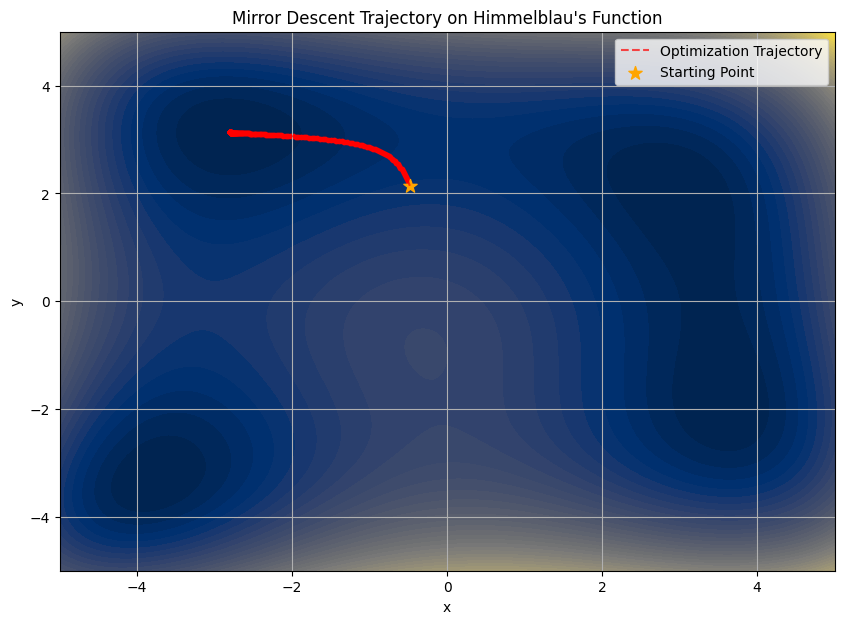

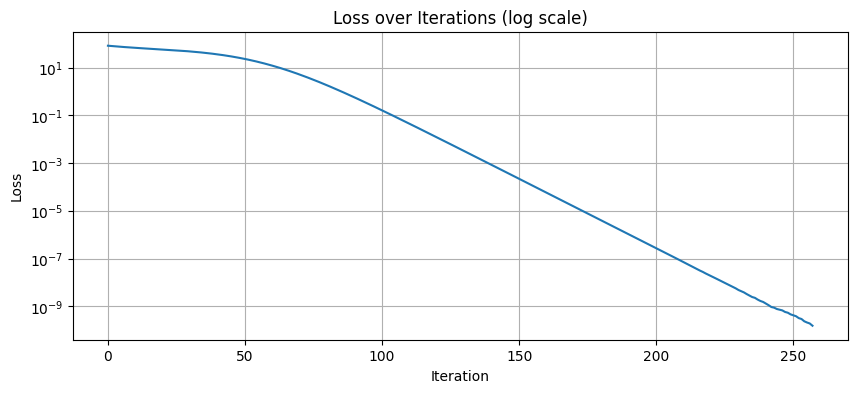

In [ ]:
import torch
from torch.optim import Optimizer
import matplotlib.pyplot as plt
import numpy as np
import time
from utils import MirrorDescent, barycentric_to_cartesian, entropic_mirror_map, test_loop

class GeneralMirrorOptimizer(Optimizer):
    def __init__(self, params, lr, mirror_map, mode="mirror"):
        if lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if mode not in ["mirror", "dual"]:
            raise ValueError(f"Invalid mode: {mode}, choose 'mirror' or 'dual'")
        defaults = dict(lr=lr, mirror_map=mirror_map, mode=mode)
        super(GeneralMirrorOptimizer, self).__init__(params, defaults)

        # For Dual Averaging, keep track of gradient sum and iteration count
        if mode == "dual":
            self.state['grad_sum'] = [torch.zeros_like(p.data) for group in self.param_groups for p in group['params']]
            self.state['t'] = 0

    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        mode = self.param_groups[0]['mode']
        lr = self.param_groups[0]['lr']
        mirror_map = self.param_groups[0]['mirror_map']

        if mode == "dual":
            self.state['t'] += 1
            t = self.state['t']
            idx = 0
            for group in self.param_groups:
                for p in group['params']:
                    if p.grad is not None:
                        grad = p.grad.data
                        self.state['grad_sum'][idx] += grad
                        avg_grad = self.state['grad_sum'][idx] / t
                        p.data = -lr * avg_grad
                        # ✅ Project into bounded region [-5, 5]
                        p.data = torch.clamp(p.data, -5.0, 5.0)
                        idx += 1

        elif mode == "mirror":
            for group in self.param_groups:
                for p in group['params']:
                    if p.grad is not None:
                        grad = p.grad.data
                        p.data = mirror_map(p.data - lr * grad)
                        # ✅ Project into bounded region [-5, 5]
                        p.data = torch.clamp(p.data, -5.0, 5.0)

        return loss


def positive_orthant_mirror_map(x):
    # Softplus ensures positivity, but here we use clamping for simplicity
    return torch.clamp(x, min=0.0)

# Himmelblau's function
def himmelblau(x):
    x1, x2 = x[0], x[1]
    return (x1**2 + x2 - 11)**2 + (x1 + x2**2 - 7)**2

# Gradient of Himmelblau's function
def grad_himmelblau(x):
    x1, x2 = x[0], x[1]
    df_dx = 4 * x1 * (x1**2 + x2 - 11) + 2 * (x1 + x2**2 - 7)
    df_dy = 2 * (x1**2 + x2 - 11) + 4 * x2 * (x1 + x2**2 - 7)
    return torch.tensor([df_dx, df_dy], dtype=torch.float32)

x = torch.nn.Parameter(torch.rand(2, dtype=torch.float32) * 6 - 3)

optimizer = GeneralMirrorOptimizer([x], lr=1e-3, mirror_map=mirror_map, mode="mirror")

trajectory = [x.detach().clone()]
losses = []
tolerance = 1.5e-4

start_time = time.time()

for i in range(50000):
    optimizer.zero_grad()
    loss = himmelblau(x)
    loss.backward()
    optimizer.step()

    trajectory.append(x.detach().clone())
    losses.append(loss.item())

    grad_norm = torch.norm(x.grad.detach())
    if grad_norm < tolerance:
        print(f"Early stopping at step {i}, final point: {x.detach()}, grad norm: {grad_norm:.6f}")
        break

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

# Print threshold info
thresholds = [10.0, 1.0, 0.1, 0.01]
for t in thresholds:
    steps = next((i for i, l in enumerate(losses) if l < t), None)
    if steps is not None:
        print(f"Loss < {t} reached at iteration {steps}")
    else:
        print(f"Loss < {t} not reached")

# Plot optimization trajectory over Himmelblau surface
trajectory = torch.stack(trajectory).numpy()
X, Y = np.meshgrid(np.linspace(-5, 5, 400), np.linspace(-5, 5, 400))
Z = (X**2 + Y - 11)**2 + (X + Y**2 - 7)**2

# Recompute function values along trajectory
traj_x = trajectory[:, 0]
traj_y = trajectory[:, 1]
function_values = []
for x_np, y_np in zip(traj_x, traj_y):
    x_torch = torch.tensor([x_np, y_np], dtype=torch.float32)
    function_values.append(himmelblau(x_torch).item())

# Prepare contour plot again
t1 = np.linspace(-5, 5, 200)
t2 = np.linspace(-5, 5, 200)
T1, T2 = np.meshgrid(t1, t2)
F = (T1**2 + T2 - 11)**2 + (T1 + T2**2 - 7)**2

plt.figure(figsize=(10, 7))
plt.contourf(T1, T2, F, levels=50, cmap="cividis")
plt.plot(traj_x, traj_y, color='red', linestyle='dashed', alpha=0.7, label='Optimization Trajectory')
plt.scatter(traj_x, traj_y, color='red', s=10)
plt.scatter(traj_x[0], traj_y[0], color='orange', marker='*', label='Starting Point', s=100)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Mirror Descent Trajectory on Himmelblau's Function")
plt.legend()
plt.grid(True)
plt.show()

# Final loss plot
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss over Iterations (log scale)")
plt.grid(True)
plt.show()


[Positive Orthant] Early stopping at step 407, final point: tensor([3.0000, 2.0000]), grad norm: 0.000973
[Positive Orthant] Elapsed time: 0.05 seconds


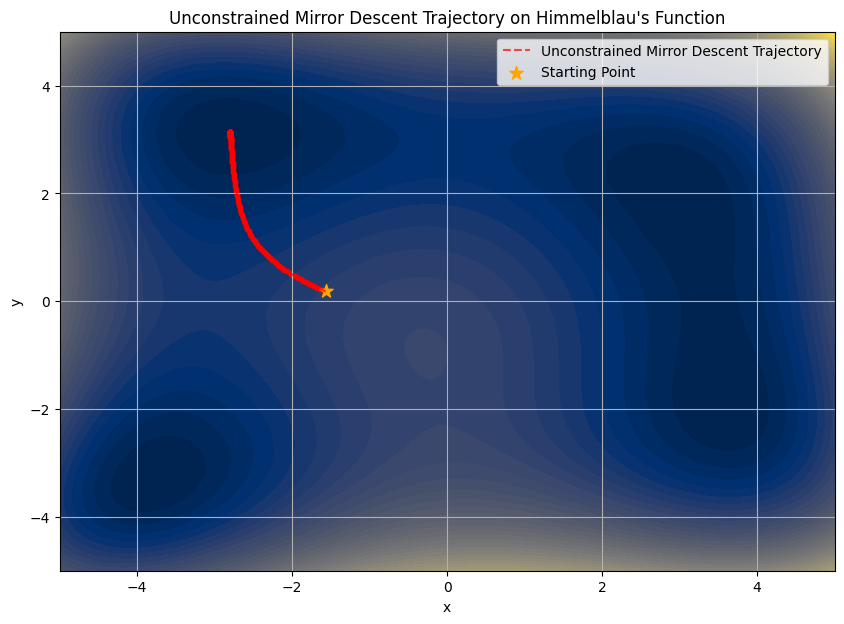

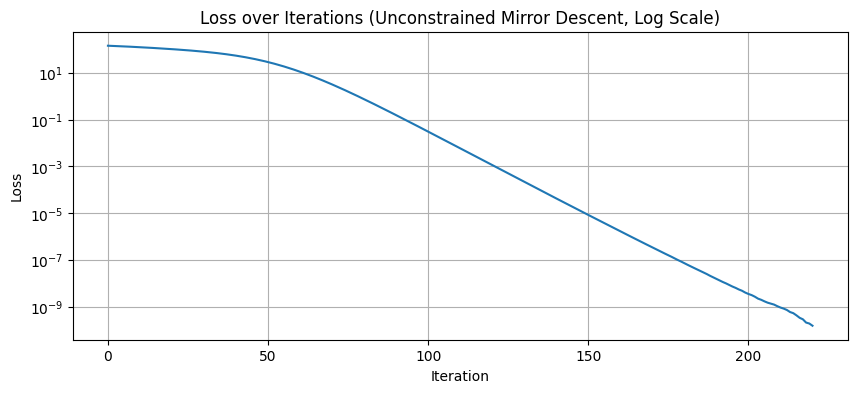

Number of recorded trajectory points: 222


In [ ]:
def positive_orthant_mirror_map(x):
    # Softplus ensures positivity, but here we use clamping for simplicity
    return torch.clamp(x, min=0.0)

# Initialize in the positive orthant
x_pos = torch.nn.Parameter(torch.rand(2, dtype=torch.float32) * 3)  # range [0, 3]

optimizer_pos = GeneralMirrorOptimizer(
    [x_pos], lr=1e-3, mirror_map=positive_orthant_mirror_map, mode="mirror"
)

trajectory_pos = [x_pos.detach().clone()]
losses_pos = []
tolerance = 1e-3

start_time_pos = time.time()

for i in range(50000):
    optimizer_pos.zero_grad()
    loss_pos = himmelblau(x_pos)
    loss_pos.backward()
    optimizer_pos.step()

    trajectory_pos.append(x_pos.detach().clone())
    losses_pos.append(loss_pos.item())

    grad_norm_pos = torch.norm(x_pos.grad.detach())
    if grad_norm_pos < tolerance:
        print(f"[Positive Orthant] Early stopping at step {i}, final point: {x_pos.detach()}, grad norm: {grad_norm_pos:.6f}")
        break

end_time_pos = time.time()
elapsed_time_pos = end_time_pos - start_time_pos
print(f"[Positive Orthant] Elapsed time: {elapsed_time_pos:.2f} seconds")

trajectory_pos = torch.stack(trajectory_pos).numpy()


traj_x = trajectory[:, 0] 
traj_y = trajectory[:, 1]
f_iters = []
for x_np, y_np in zip(traj_x, traj_y):
    x_torch = torch.tensor([x_np, y_np], dtype=torch.float32)
    f_iters.append(himmelblau(x_torch).item())

# Create contour map of Himmelblau function again
t1 = np.linspace(-5, 5, 200)
t2 = np.linspace(-5, 5, 200)
T1, T2 = np.meshgrid(t1, t2)
F = (T1**2 + T2 - 11)**2 + (T1 + T2**2 - 7)**2

plt.figure(figsize=(10, 7))
plt.contourf(T1, T2, F, levels=50, cmap="cividis")
plt.plot(traj_x, traj_y, color='red', linestyle='dashed', alpha=0.7, label='Unconstrained Mirror Descent Trajectory')
plt.scatter(traj_x, traj_y, color='red', s=10)
plt.scatter(traj_x[0], traj_y[0], color='orange', marker='*', label='Starting Point', s=100)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Unconstrained Mirror Descent Trajectory on Himmelblau's Function")
plt.legend()
plt.grid(True)
plt.show()

# Loss curve (unconstrained, log scale) — optional if already shown earlier
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss over Iterations (Unconstrained Mirror Descent, Log Scale)")
plt.grid(True)
plt.show()
print(f"Number of recorded trajectory points: {len(trajectory)}")



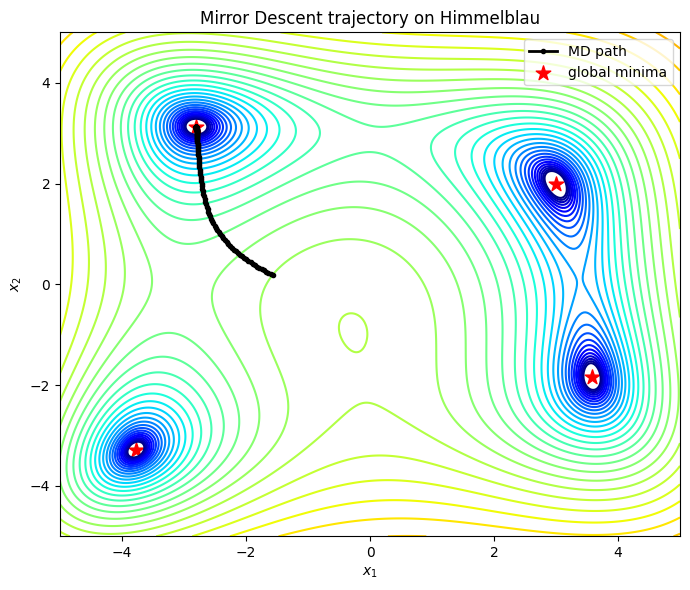

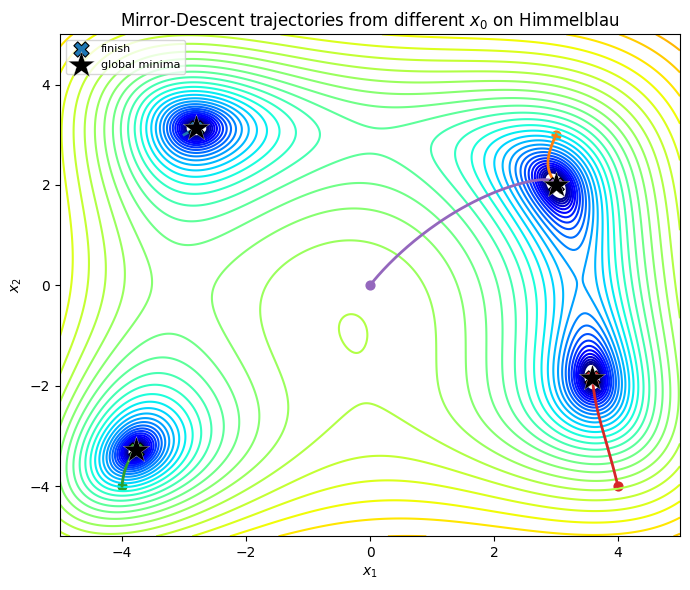

In [ ]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 400), np.linspace(-5, 5, 400))
zz = (xx**2 + yy - 11)**2 + (xx + yy**2 - 7)**2

plt.figure(figsize=(7,6))
levels = np.logspace(0, 4, 40)
plt.contour(xx, yy, zz, levels=levels, norm=LogNorm(), cmap="jet")
plt.plot(trajectory[:,0], trajectory[:,1], "k.-", lw=2, label="MD path")
plt.scatter([3.0, -2.805, -3.779, 3.584], [2.0, 3.131, -3.283, -1.848], 
            c="red", marker="*", s=120, label="global minima")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Mirror Descent trajectory on Himmelblau")
plt.legend()
plt.tight_layout()
plt.show()

init_points = [
    [-3, 3],
    [3, 3],
    [-4, -4],
    [4, -4],
    [0, 0]
]
trajectories = []
for x0 in init_points:
    x_md = torch.nn.Parameter(torch.tensor(x0, dtype=torch.float32))
    optimizer_md = GeneralMirrorOptimizer([x_md], lr=1e-3, mirror_map=mirror_map, mode="mirror")
    traj = [x_md.detach().clone()]
    for i in range(3000):
        optimizer_md.zero_grad()
        loss = himmelblau(x_md)
        loss.backward()
        optimizer_md.step()
        traj.append(x_md.detach().clone())
    trajectories.append(torch.stack(traj).numpy())

plt.figure(figsize=(7,6))
levels = np.logspace(0, 4, 40)
plt.contour(xx, yy, zz, levels=levels, cmap="jet", norm=LogNorm())

colors = plt.cm.tab10(range(len(init_points)))
for idx, (c, trj, x0) in enumerate(zip(colors, trajectories, init_points)):
    plt.plot(trj[:,0], trj[:,1], color=c, lw=2)
    plt.scatter(*x0, color=c, marker="o", s=40)
    plt.scatter(
        trj[-1,0], trj[-1,1],
        color=c,
        marker="X",
        s=120,
        edgecolors="k",
        linewidths=0.8,
        zorder=4,
        label="finish" if idx==0 else None
    )

plt.scatter(
    [3.0, -2.805, -3.779, 3.584], [2.0, 3.131, -3.283, -1.848],
    c="k", marker="*", s=400,
    edgecolors="w", linewidths=0.2,
    zorder=5, label="global minima"
)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Mirror-Descent trajectories from different $x_0$ on Himmelblau")
plt.legend(loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()

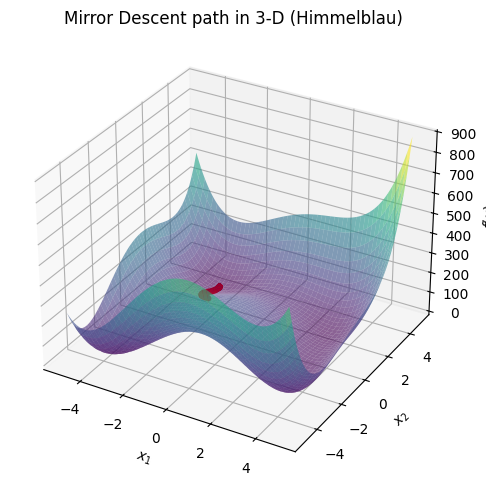

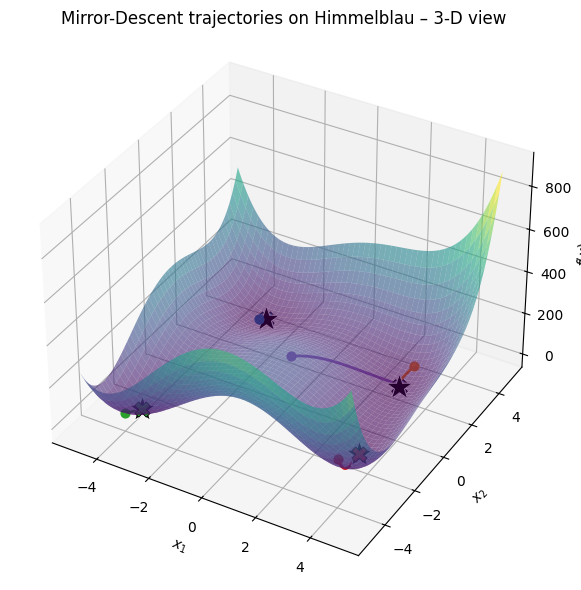

In [ ]:

xx, yy = np.meshgrid(np.linspace(-5, 5, 400), np.linspace(-5, 5, 400))
zz = (xx**2 + yy - 11)**2 + (xx + yy**2 - 7)**2

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(xx, yy, zz, rstride=8, cstride=8, alpha=0.6, cmap="viridis", lw=0.2)

ax.plot(trajectory[1:,0], trajectory[1:,1], losses, "r.-", lw=2)

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$f(x)$")
ax.set_title("Mirror Descent path in 3-D (Himmelblau)")
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(xx, yy, zz, rstride=8, cstride=8, alpha=0.6, cmap="viridis", lw=0.2)

colors = plt.cm.tab10(np.arange(len(trajectories)))
for c, trj in zip(colors, trajectories):
    f_vals = [(x1**2 + x2 - 11)**2 + (x1 + x2**2 - 7)**2 for x1, x2 in zip(trj[:,0], trj[:,1])]
    ax.plot(trj[:,0], trj[:,1], f_vals, color=c, lw=2)
    ax.scatter(trj[0,0], trj[0,1], f_vals[0], color=c, marker="o", s=40, zorder=4)
    ax.scatter(trj[-1,0], trj[-1,1], f_vals[-1], color=c, marker="X", s=120,
               edgecolors="k", linewidths=0.6, zorder=5)

for x_star, y_star in zip([3.0, -2.805, -3.779, 3.584], [2.0, 3.131, -3.283, -1.848]):
    f_star = (x_star**2 + y_star - 11)**2 + (x_star + y_star**2 - 7)**2
    ax.scatter(x_star, y_star, f_star, c="k", marker="*", s=400,
               edgecolors="w", linewidths=0.8, zorder=6, label="global min" if x_star==3.0 else None)

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$f(x)$")
ax.set_title("Mirror-Descent trajectories on Himmelblau – 3-D view")
ax.view_init(elev=35, azim=-60)
plt.tight_layout()
plt.show()